## 선별 개별 종목에 대한 알맞은 가중치 구성법

### 개별 종목 머지

In [555]:
import pandas as pd
from pykrx import stock


In [556]:
start_date = f'20200101'
end_date = f'20211231'

symbols = [ '035420', '196170', '042700', '005930'] # 네이버, 알트로젠, 한미반도체, 삼성전자

In [557]:
# dataframe concat
stock_df = pd.DataFrame()
for symbol in symbols:
    stock_df[symbol] = stock.get_market_ohlcv_by_date(start_date, end_date, symbol)['종가'] # 네이버

stock_df

,035420,196170,042700,005930
날짜,,,,
2020-01-02,182500,19413,3980,55200
2020-01-03,181500,18746,3985,55500
2020-01-06,180500,17494,3920,55500
2020-01-07,187000,17995,3925,55800
2020-01-08,183000,16883,3925,56800
...,...,...,...,...
2021-12-24,384000,58389,18050,80500
2021-12-27,380500,59807,18300,80200
2021-12-28,384500,62809,18425,80300


In [558]:
# 데일리 수익률
daily_return = stock_df.pct_change(periods=1) # shift and percent 까지 해서 수익률 나옴.
daily_return

,035420,196170,042700,005930
날짜,,,,
2020-01-02,NaN,NaN,NaN,NaN
2020-01-03,-0.005479,-0.034358,0.001256,0.005435
2020-01-06,-0.005510,-0.066788,-0.016311,0.000000
2020-01-07,0.036011,0.028638,0.001276,0.005405
2020-01-08,-0.021390,-0.061795,0.000000,0.017921
...,...,...,...,...
2021-12-24,0.015873,-0.014082,0.000000,0.007509
2021-12-27,-0.009115,0.024285,0.013850,-0.003727
2021-12-28,0.010512,0.050195,0.006831,0.001247


In [559]:
# 리스크 점수 구하기 
annual_return = daily_return.mean() * 252
annual_return

035420    0.437258
196170    0.883705
042700    0.946450
005930    0.217409
dtype: float64

In [560]:
daily_cov = daily_return.cov()
daily_cov

,035420,196170,042700,005930
035420,0.000526,0.000409,0.000260,0.000159
196170,0.000409,0.002319,0.000473,0.000185
042700,0.000260,0.000473,0.001220,0.000283
005930,0.000159,0.000185,0.000283,0.000315


In [561]:
annual_cov = daily_cov * 252
annual_cov

,035420,196170,042700,005930
035420,0.132514,0.102990,0.065583,0.039966
196170,0.102990,0.584310,0.119117,0.046511
042700,0.065583,0.119117,0.307320,0.071432
005930,0.039966,0.046511,0.071432,0.079495


### 비율 생성과 정규화 

In [562]:
import numpy as np

In [563]:
# 비율 랜덤 생성
weights = np.random.random(len(symbols))
weights, type(weights), weights.shape

(array([0.06334808, 0.1168283 , 0.70805683, 0.97732926]), numpy.ndarray, (4,))

In [564]:
# 비율 정규화 
weights = weights / np.sum(weights)
weights, type(weights), weights.shape, np.sum(weights)

(array([0.03395656, 0.06262363, 0.37954067, 0.52387914]),
 numpy.ndarray,
 (4,),
 1.0)

In [565]:
return_of_rate = np.dot(weights, annual_return)
return_of_rate, type(return_of_rate) # y축 값 수익률 

(0.5433008867794505, numpy.float64)

In [566]:
np.dot(annual_cov, weights)

array([0.05677798, 0.10966483, 0.16374849, 0.07302687])

In [567]:
np.dot(weights.T, np.dot(annual_cov, weights))

0.10920206365468976

In [568]:
risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))
risk, type(risk) # x축 값 리스크

(0.3304573552740047, numpy.float64)

In [569]:
# 여러 포트폴리오 비율 적용
fiture_count = 1000
portfolio_return_of_rate = []
portfolio_risk = []
portfolio_weights = []
for num in range(fiture_count):
    weights = np.random.random(len(symbols))
    weights = weights / np.sum(weights)
    return_of_rate = np.dot(weights, annual_return) # y
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) # x

    portfolio_return_of_rate.append(return_of_rate)
    portfolio_risk.append(risk)
    portfolio_weights.append(weights)



In [570]:
# Convert Dataframe : Return of rate, Rist, weights
portfolio = {
    "Return_of_rate" : portfolio_return_of_rate,
    "Risk" : portfolio_risk
}

for idx, symbol in enumerate(symbols):
    portfolio[symbol] =  [weight[idx] for weight in portfolio_weights]


df_portfolio = pd.DataFrame(portfolio)
df_portfolio.head()

,Return_of_rate,Risk,035420,196170,042700,005930
0,0.590383,0.351114,0.314304,0.270825,0.169297,0.245574
1,0.672281,0.387310,0.155726,0.319433,0.285031,0.239810
2,0.744330,0.472665,0.297653,0.488316,0.186710,0.027321
3,0.610518,0.348524,0.274046,0.243663,0.233881,0.248410
4,0.596179,0.364013,0.300521,0.308016,0.147414,0.244049


In [571]:
df_portfolio[['Return_of_rate', 'Risk']].head()

,Return_of_rate,Risk
0,0.590383,0.351114
1,0.672281,0.387310
2,0.744330,0.472665
3,0.610518,0.348524
4,0.596179,0.364013


In [572]:
df_portfolio[['035420','196170','042700','005930']].head()

,035420,196170,042700,005930
0,0.314304,0.270825,0.169297,0.245574
1,0.155726,0.319433,0.285031,0.239810
2,0.297653,0.488316,0.186710,0.027321
3,0.274046,0.243663,0.233881,0.248410
4,0.300521,0.308016,0.147414,0.244049


### Chart 작성

In [573]:
import matplotlib.pyplot as plt
import matplotlib as mpl # 한글 폰트 설정 (NanumGothic) 
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

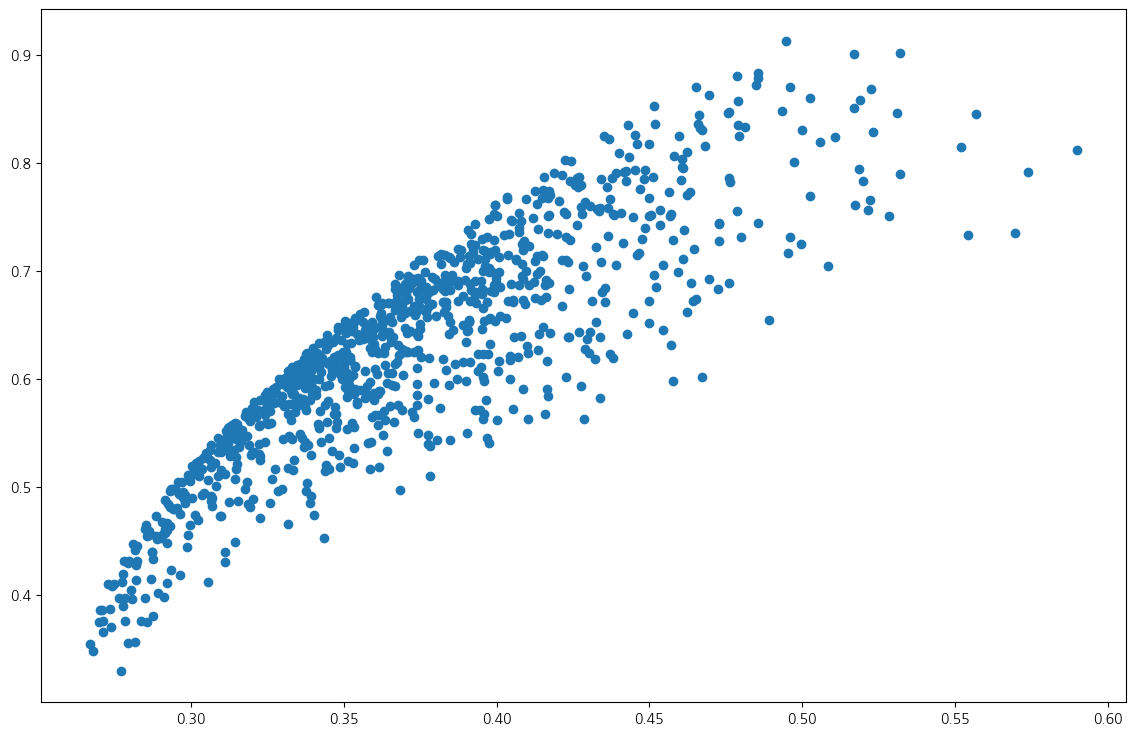

In [574]:
plt.figure(figsize=(14,9), dpi=100)
plt.scatter(df_portfolio['Risk'], df_portfolio['Return_of_rate'])
plt.show()
# 최외곽에 가까운 지점의 weight 만큼 종목에 투자